# Reguralization (Dropout, Normalization)

# Library

In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# Load Dataset and Preprocess

In [2]:
from tensorflow.keras.datasets import mnist as data

# load dataset
(x_train, y_train), (x_test, y_test) = data.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

train_n_sample = len(x_train)
shape = x_train[0].shape[0:]
n_class = len(np.unique(y_train))
print(train_n_sample, shape, n_class)

# x reshape and x normalization
X_train = x_train.reshape(-1, np.prod(shape)) / 255.
X_test = x_test.reshape(-1, np.prod(shape)) / 255.

# y onehot
Y_train = np.eye(n_class)[y_train.reshape(-1)]
Y_test = np.eye(n_class)[y_test.reshape(-1)]

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

11493376/11490434 [==============================] - 3s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
60000 (28, 28) 10
(60000, 784) (10000, 784) (60000, 10) (10000, 10)


# Multi-Layer Perceptron (MLP) with Regularization

## Hyper-parameter setting

In [3]:
# hyper parameter setting
training_epochs = 100
learning_rate = 1e-1
display_step = 10

batch_size = 100

hidden_nodes = [1024, 300]
activation = tf.nn.tanh
# norm

# dropout rate
dropout_rate = 0.2

## Build Model

In [4]:
hidden_nodes

[1024, 300]

In [5]:
tf.contrib.layers.dropout?

In [8]:
# build 3-layer fully-connected neural network model
# hidden layers' size is [1024, 300]
tf.reset_default_graph()

# placeholder
tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))
is_train = tf.placeholder(tf.bool, [])
# model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
# norm, dropout
norm1 = tf.contrib.layers.batch_norm(output1, is_training=True)
dropout1 = tf.contrib.layers.dropout(norm1, keep_prob=1-dropout_rate, is_training=is_train)
hidden1 = activation(dropout1)

output2 = tf.layers.dense(hidden1, hidden_nodes[1])
# norm, dropout
norm2 = tf.contrib.layers.batch_norm(output2, is_training=True)
dropout2 = tf.contrib.layers.dropout(norm2, keep_prob=1-dropout_rate, is_training=is_train)
hidden2 = activation(dropout2)
# norm, dropout

logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
# batch norm optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) #DON_T USE THIS

## Train model

In [12]:
with tf.Session() as sess:
    # init
    sess.run(tf.global_variables_initializer())

    # train
    epoch_losses, iter_losses = [], []
    total_batch = int( train_n_sample / batch_size )
    for epoch in range(training_epochs):
        # shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]

        for i in range(total_batch):
            # get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]

            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train, is_train:True})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))

        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))

    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train, is_train:False})
    test_pred = sess.run(pred, feed_dict={tf_X:X_test, is_train:False})

    # save
    saver = tf.train.Saver()
    saver.save(sess, 'model')

Epoch: 10, 	 Loss: 0.05162860080599785
Epoch: 20, 	 Loss: 0.024237800389528275
Epoch: 30, 	 Loss: 0.017222397029399872
Epoch: 40, 	 Loss: 0.01137265283614397
Epoch: 50, 	 Loss: 0.009596860967576504
Epoch: 60, 	 Loss: 0.008478210307657719
Epoch: 70, 	 Loss: 0.006093813106417656
Epoch: 80, 	 Loss: 0.005387012846767902
Epoch: 90, 	 Loss: 0.004847005009651184
Epoch: 100, 	 Loss: 0.005149906501173973


## Plot result

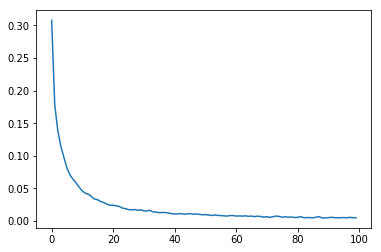

train  accuracy:  0.9999666666666667
test  accuracy:  0.9808
[[ 973    2    1    0    1    1    0    1    1    0]
 [   0 1125    4    0    0    0    2    1    3    0]
 [   5    3 1005    0    2    0    2    8    6    1]
 [   0    0    4  993    0    3    0    4    4    2]
 [   2    0    0    1  966    0    4    2    2    5]
 [   3    0    0    8    1  870    5    1    2    2]
 [   4    2    0    0    3    5  942    0    2    0]
 [   1    2    7    1    2    0    0 1009    3    3]
 [   4    1    5    5    2    3    0    6  945    3]
 [   3    3    0    6    8    1    0    6    2  980]]


In [13]:
# plot epoch losses
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
plot_epoch_losses(epoch_losses)

# accuracy
def print_accuracy(label, pred, name=''):
    accuracy = np.mean(label==pred)
    print(name, ' accuracy: ', accuracy)
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')

# confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))